# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Проведем предобработку данных, анализ и выявим закономерности

### Откроем файл с данными и изучим общую информацию.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


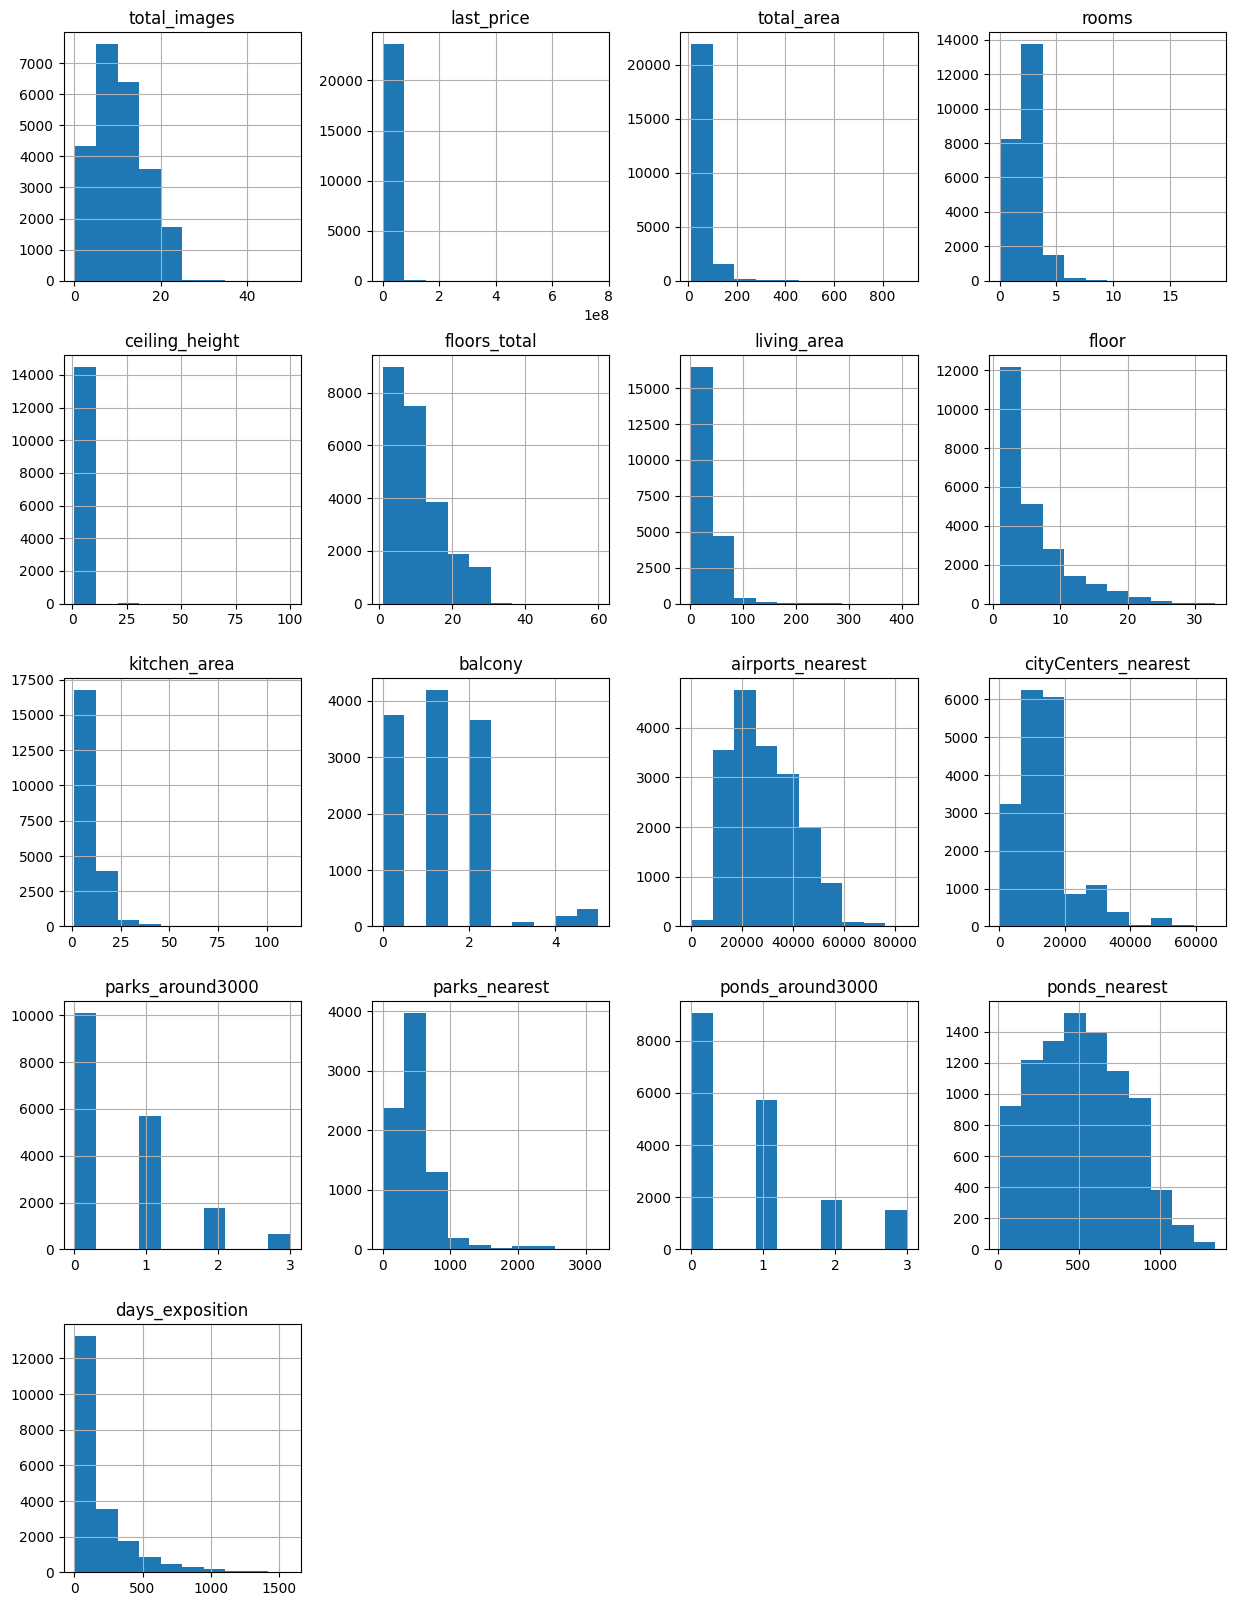

In [3]:
try:
    data = pd.read_csv('/content/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

display(data.info())
data.hist(figsize=(15, 20))
data.head()



Данные просмотренны и можно сделать вывод что данные иемют некоректные значения и требуют предобработки

### Предобработка данных

In [4]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})


In [5]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

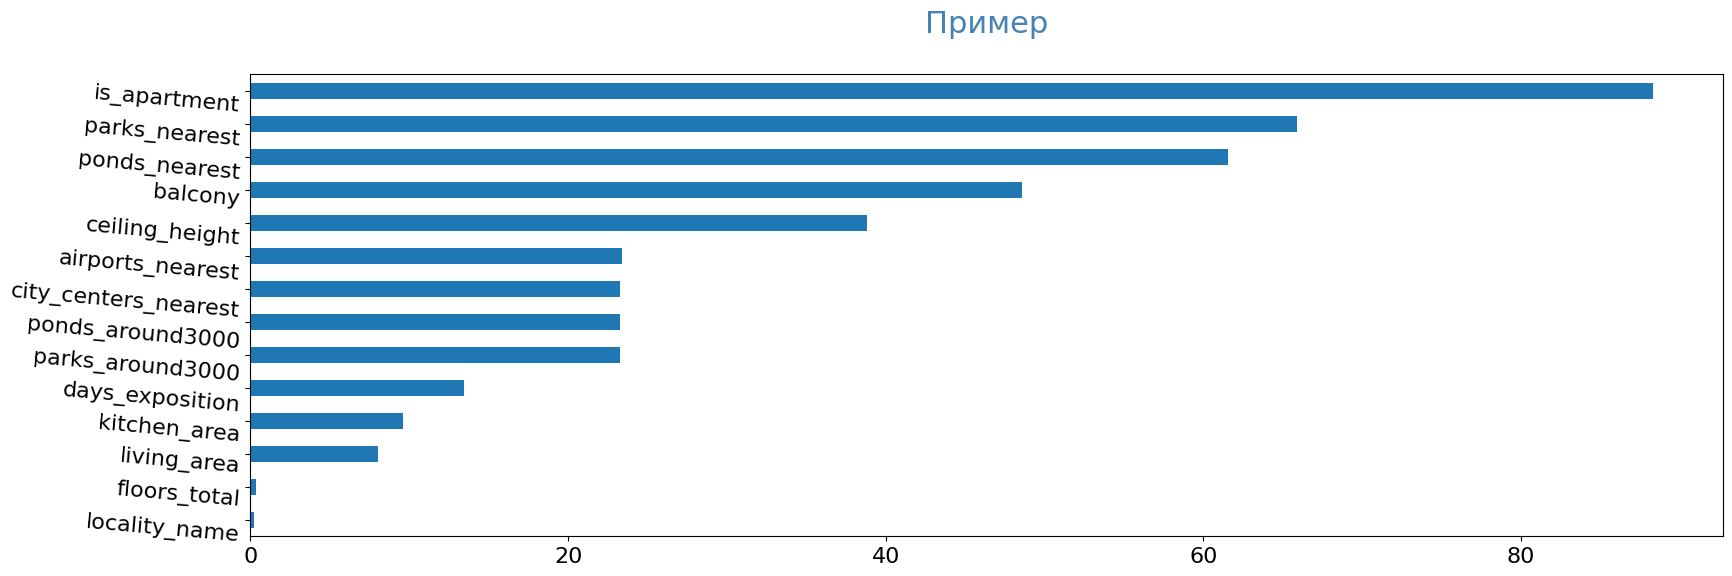

In [6]:
pass_value_barh(data)

In [7]:
data['balcony'] = data['balcony'].fillna(value = 0).astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].fillna(value = 0).astype(int)
data['is_apartment'] = data['is_apartment'].fillna(value = 0).astype(bool)
data['parks_around3000'] = data['parks_around3000'].fillna(value = 0).astype(int)
data['ponds_around3000'] = data['ponds_around3000'].fillna(value = 0).astype(int)
data['days_exposition'] = data['days_exposition'].fillna(value = 0).astype(int)

kf_1_kitchen_area_1 = data.loc[data['kitchen_area']> 0]
kf_1_kitchen_area = kf_1_kitchen_area_1['kitchen_area'].mean()
kf_1_total_area = kf_1_kitchen_area_1['total_area'].mean()
kf_1 = kf_1_kitchen_area/kf_1_total_area
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*kf_1).round()

kf_2_living_area_2 = data.loc[data['living_area'] >0]
kf_2_living_area = kf_2_living_area_2['living_area'].mean()
kf_2_total_area = kf_2_living_area_2['total_area'].mean()
kf_2 = kf_2_living_area/kf_2_total_area
data['living_area'] = data['living_area'].fillna(data['total_area']*kf_1).round()
data = data.loc[data['total_area']*0.9  > (data['living_area'] + data['kitchen_area'])]
(data['total_area']*0.9 <= (data['living_area'] + data['kitchen_area'])).value_counts()




False    23065
dtype: int64

пропушенные значения столбца 'ceiling_height' не заменяются на показатели из за отсутствия кореляции
пропушенные значения столбца 'floors_total' не заменяются на показатели из за отсутствия кореляции
тип значений столбца 'balcony' измениется int так как их количетсво может имкеть только целочисленные значения, пропуски этого столбца заменяются на 0, аналогичная опперация проводится со столбцами 'parks_around3000', 'ponds_around3000', 'days_exposition', 'floors_total'
тип значений столбца 'is_apartment' меняется на булев

так же заменим пропуски в столбцах 'living_area' и 'kitchen_area' отталкваясь от кф пирсона отношением к 'total_area'

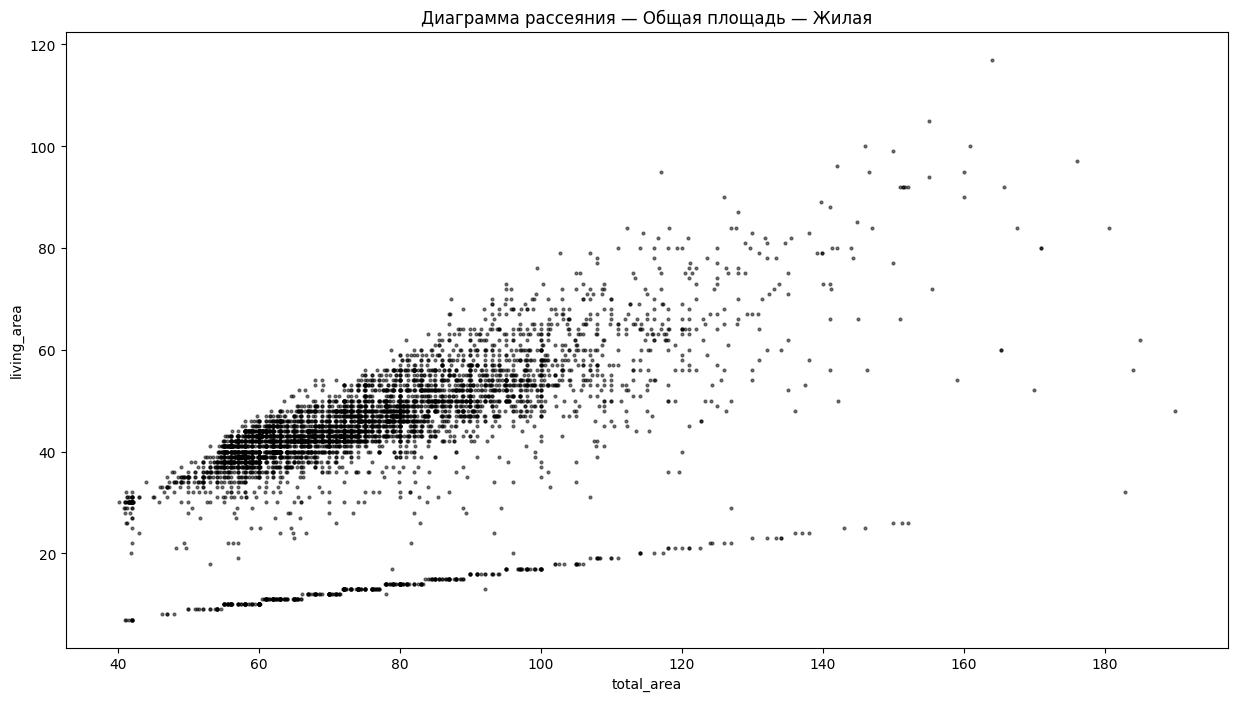

In [8]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

In [9]:
print(data['locality_name'].nunique())
print()
#data['locality_name'].unique()

361



In [10]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] =  data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] =  data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок')
data['locality_name'] =  data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] =  data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'] =  data['locality_name'].str.replace('садоводческое некоммерческое товарищество','садоводство')
data['locality_name'] =  data['locality_name'].str.replace('садовое товарищество', 'садоводство')
data['locality_name'].nunique()


318

#### check name

In [11]:


data.loc[(data['ceiling_height'] < 2.5) | (data['ceiling_height'] > 10), 'ceiling_height'] = None
data['ceiling_height'].mean()
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23065 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23065 non-null  int64         
 1   last_price            23065 non-null  float64       
 2   total_area            23065 non-null  float64       
 3   first_day_exposition  23065 non-null  datetime64[ns]
 4   rooms                 23065 non-null  int64         
 5   ceiling_height        23065 non-null  float64       
 6   floors_total          23065 non-null  int64         
 7   living_area           23065 non-null  float64       
 8   floor                 23065 non-null  int64         
 9   is_apartment          23065 non-null  bool          
 10  studio                23065 non-null  bool          
 11  open_plan             23065 non-null  bool          
 12  kitchen_area          23065 non-null  float64       
 13  balcony         



В интеренете была найдена информацция о госта высоты потолка минимально допустимая высота потолка 2.5 метра. максимальная высота в квартирах жилого назначения 4.0 метра, значит данные вне этих пареаметров считаются ошибками

Пропуски в столбце с высотой потолков заменяем медианным значением отфилтрованных данных



total_images            22807
last_price              22807
total_area              22807
first_day_exposition    22807
rooms                   22807
ceiling_height          22807
floors_total            22807
living_area             22807
floor                   22807
is_apartment            22807
studio                  22807
open_plan               22807
kitchen_area            22807
balcony                 22807
locality_name           22807
airports_nearest        17500
city_centers_nearest    17521
parks_around3000        22807
parks_nearest            7761
ponds_around3000        22807
ponds_nearest            8731
days_exposition         22807
dtype: int64

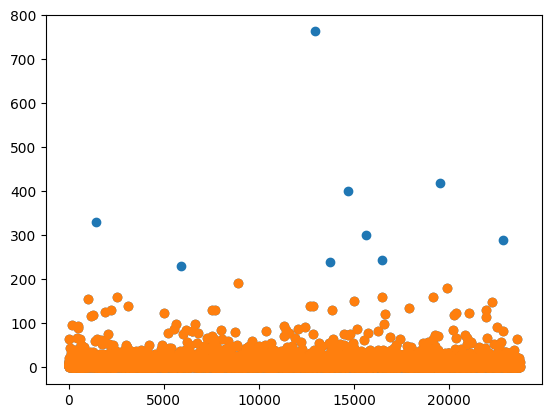

In [13]:
data = data.dropna(subset= ['locality_name']) # удаляем строки с пропусками
data['rooms'].unique() # удалим строки, где комнат больше 14
data = data.query('rooms < 14 or rooms.isna() == True')
data['last_price'] = data['last_price']/1000000 #цена будет указана в млн
data['last_price'].plot(style = 'o')
data = data.query('0.5 <= last_price <= 200 or last_price.isna() == True')
data['last_price'].plot(style = 'o')
data = data.query('2 <= floors_total <= 60')
data = data.query('4<=living_area<184')
data= data.query('4 < = kitchen_area < 77')
data.count()

total_images            22745
last_price              22745
total_area              22745
first_day_exposition    22745
rooms                   22745
ceiling_height          22745
floors_total            22745
living_area             22745
floor                   22745
is_apartment            22745
studio                  22745
open_plan               22745
kitchen_area            22745
balcony                 22745
locality_name           22745
airports_nearest        17439
city_centers_nearest    17460
parks_around3000        22745
parks_nearest            7724
ponds_around3000        22745
ponds_nearest            8690
days_exposition         22745
dtype: int64

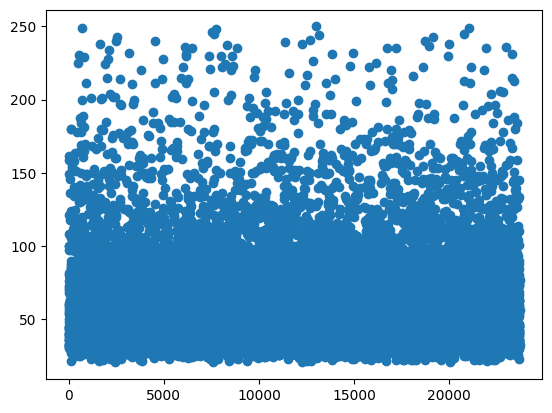

In [14]:
#data['total_area'].plot(style = 'o')
data = data.query('total_area < 250 or total_area.isna() == True')
data['total_area'].plot(style = 'o')
data.count()

#### check nan

In [15]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22745 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22745 non-null  int64         
 1   last_price            22745 non-null  float64       
 2   total_area            22745 non-null  float64       
 3   first_day_exposition  22745 non-null  datetime64[ns]
 4   rooms                 22745 non-null  int64         
 5   ceiling_height        22745 non-null  float64       
 6   floors_total          22745 non-null  int64         
 7   living_area           22745 non-null  float64       
 8   floor                 22745 non-null  int64         
 9   is_apartment          22745 non-null  bool          
 10  studio                22745 non-null  bool          
 11  open_plan             22745 non-null  bool          
 12  kitchen_area          22745 non-null  float64       
 13  balcony         

total_images            19689
last_price              19689
total_area              19689
first_day_exposition    19689
rooms                   19689
ceiling_height          19689
floors_total            19689
living_area             19689
floor                   19689
is_apartment            19689
studio                  19689
open_plan               19689
kitchen_area            19689
balcony                 19689
locality_name           19689
airports_nearest        15222
city_centers_nearest    15242
parks_around3000        19689
parks_nearest            6629
ponds_around3000        19689
ponds_nearest            7530
days_exposition         19689
dtype: int64


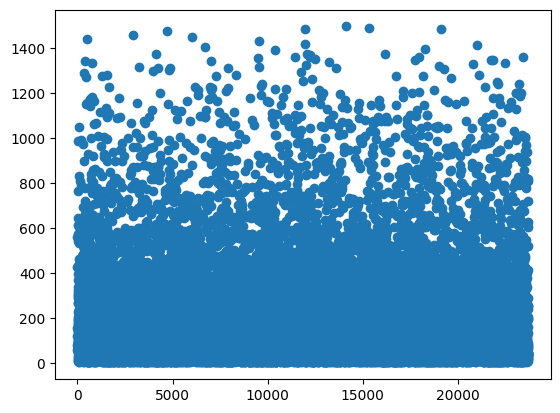

In [16]:

data = data.query('1<= days_exposition <= 1500 or days_exposition.isna() == True')
data['days_exposition'].plot(style = 'o')
print(data.count())

In [17]:
# check
data.shape[0]

19689

Найдя еще некоректные данные(пропуски и выбросы) избавимся от жтих значений

#### check gap

In [18]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19689 entries, 1 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19689 non-null  int64         
 1   last_price            19689 non-null  float64       
 2   total_area            19689 non-null  float64       
 3   first_day_exposition  19689 non-null  datetime64[ns]
 4   rooms                 19689 non-null  int64         
 5   ceiling_height        19689 non-null  float64       
 6   floors_total          19689 non-null  int64         
 7   living_area           19689 non-null  float64       
 8   floor                 19689 non-null  int64         
 9   is_apartment          19689 non-null  bool          
 10  studio                19689 non-null  bool          
 11  open_plan             19689 non-null  bool          
 12  kitchen_area          19689 non-null  float64       
 13  balcony         

In [21]:

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"19,689.00","19,689.00","19,689.00","19,689.00","19,689.00","19,689.00","19,689.00","19,689.00","19,689.00"
min,0.00,21.00,2.50,1.00,0.50,4.00,4.00,1.00,2.00
max,11.00,249.00,8.30,"1,497.00",160.00,180.00,75.00,33.00,60.00


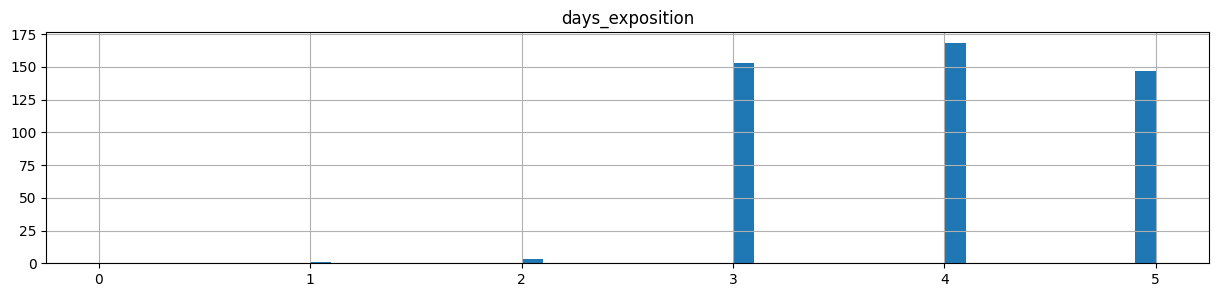

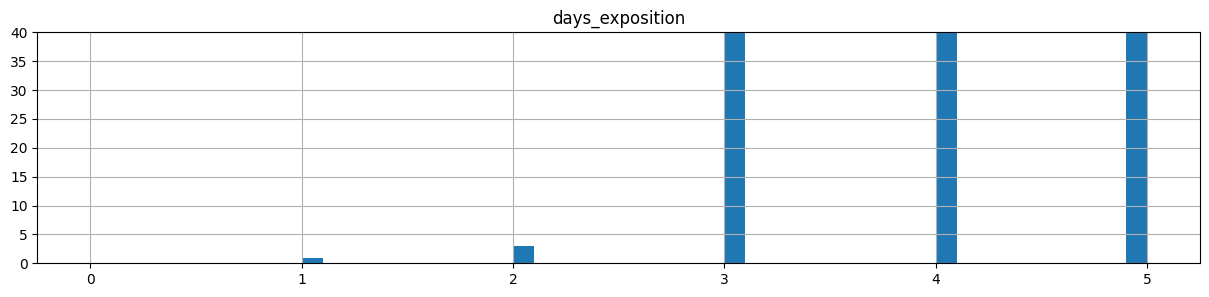

In [22]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [23]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [24]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


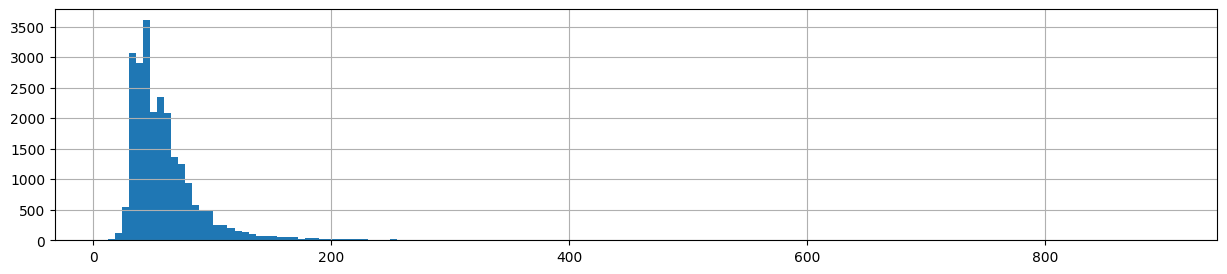

In [25]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

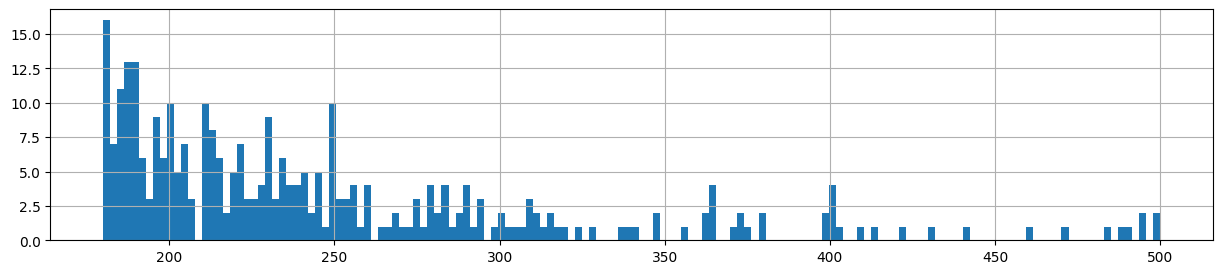

In [26]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

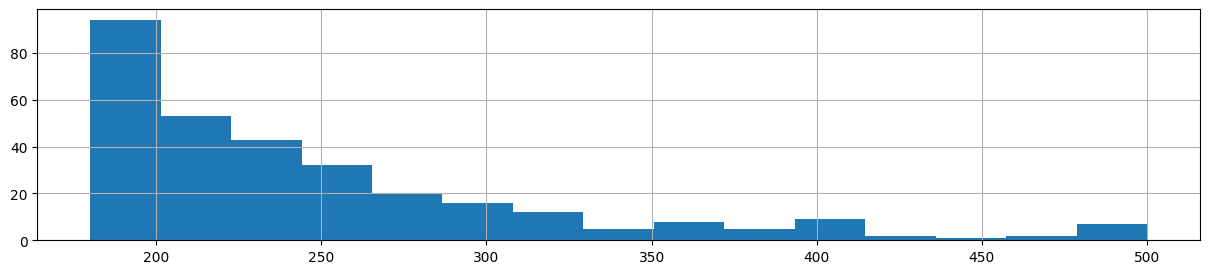

In [27]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

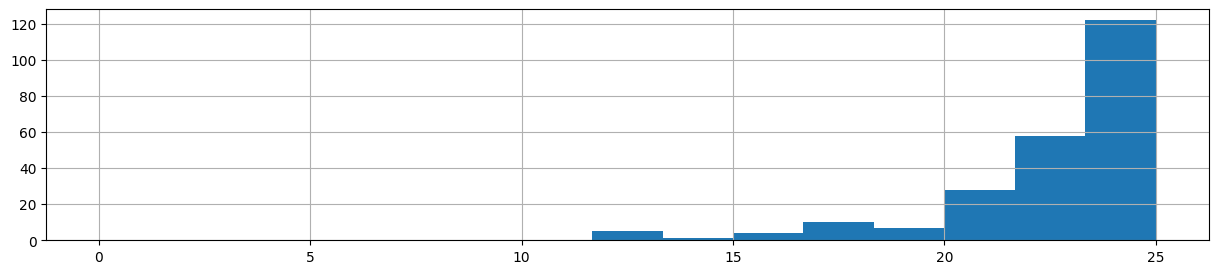

In [28]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [29]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,0.00,22.46,2.50,3.00,0.60,5.00,4.00,1.00,2.00
0.010000,1.00,27.00,2.50,4.00,1.10,6.00,5.00,1.00,2.00
0.500000,2.00,50.70,2.65,95.00,4.50,28.00,9.00,4.00,9.00
0.990000,5.00,167.01,3.50,"1,061.36",27.84,96.00,30.00,23.00,26.00
0.998800,7.00,231.75,4.19,"1,349.37",69.95,151.00,50.00,26.00,30.50


### Посчитайте и добавьте в таблицу новые столбцы

In [30]:
from numpy.core.fromnumeric import around
data['sale_m'] = data['last_price'] / data['total_area'] #столбец цены за метр
data['day_week'] = data['first_day_exposition'].dt.day_name()
data['nom_month'] = data['first_day_exposition'].dt.month
data['nom_year'] = data['first_day_exposition'].dt.year
data['type_floor'] = data.loc[(data['floor'] != 1) & (data['floor'] != data['floors_total']), 'type_floor'] = 'other'
data.loc[data['floor'] == data['floors_total'], 'type_floor'] = 'last'
data.loc[data['floor'] == 1, 'type_floor'] = 'first'
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)



#data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19689 entries, 1 to 23697
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             19689 non-null  int64         
 1   last_price               19689 non-null  float64       
 2   total_area               19689 non-null  float64       
 3   first_day_exposition     19689 non-null  datetime64[ns]
 4   rooms                    19689 non-null  int64         
 5   ceiling_height           19689 non-null  float64       
 6   floors_total             19689 non-null  int64         
 7   living_area              19689 non-null  float64       
 8   floor                    19689 non-null  int64         
 9   is_apartment             19689 non-null  bool          
 10  studio                   19689 non-null  bool          
 11  open_plan                19689 non-null  bool          
 12  kitchen_area             19689 n

### Проведите исследовательский анализ данных

Text(0.5, 1.0, 'Distribution of Different Area Types')

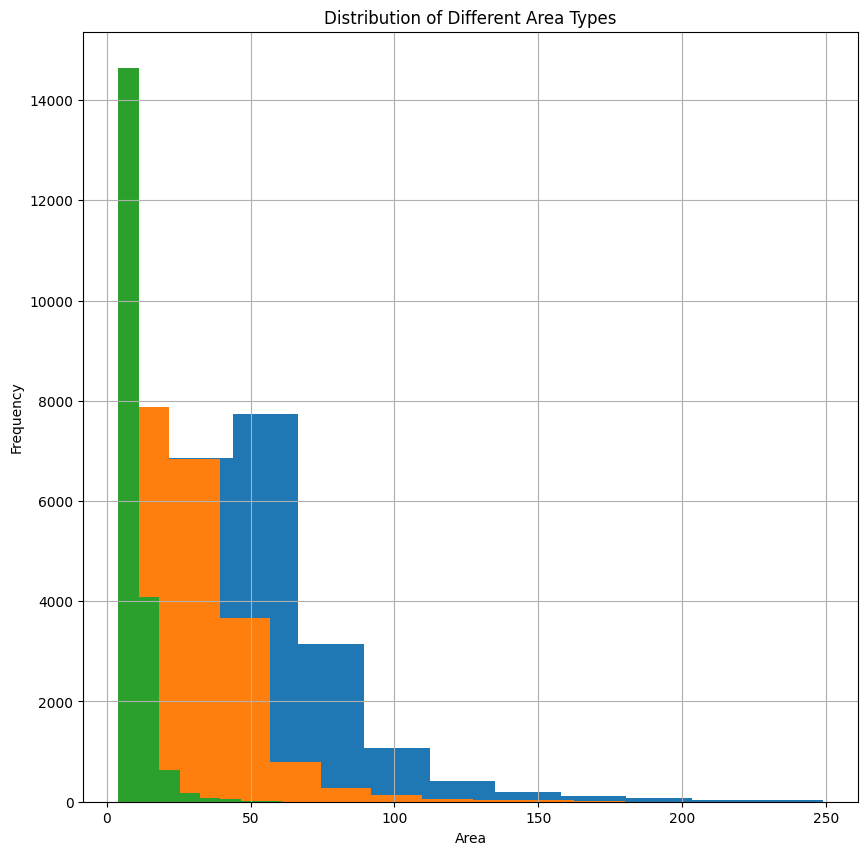

In [31]:
plt.figure(figsize=(10, 10))
data['total_area'].hist() #площадь квартир в основном до 200мквадратных
data['living_area'].hist() #площадь гостинной в квартирах в основном до 20 мквадратных
data['kitchen_area'].hist() #площадь кухонь в квартирах в основном до 20 мквадратных

plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Distribution of Different Area Types')

<Axes: >

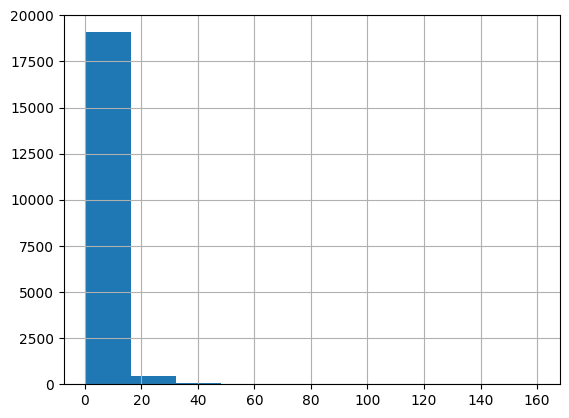

In [32]:
data['last_price'].hist() #

<Axes: >

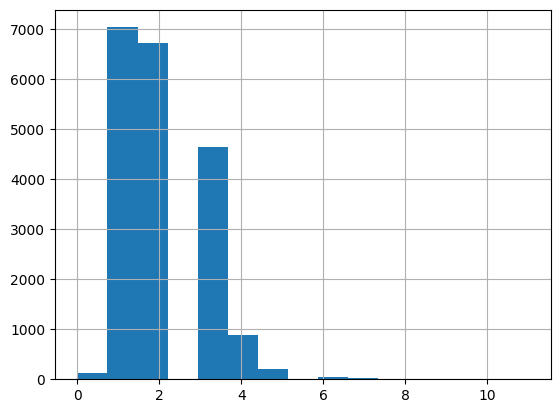

In [33]:
data['rooms'].hist(bins = 15) #больше всего квартир с 1,2 и 3 комнатами

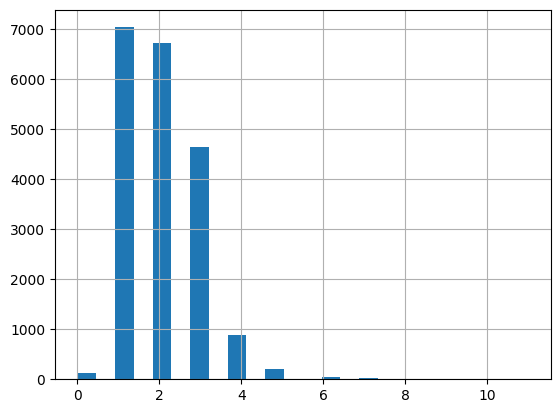

In [34]:
data['rooms'].hist(bins = 24);

<Axes: >

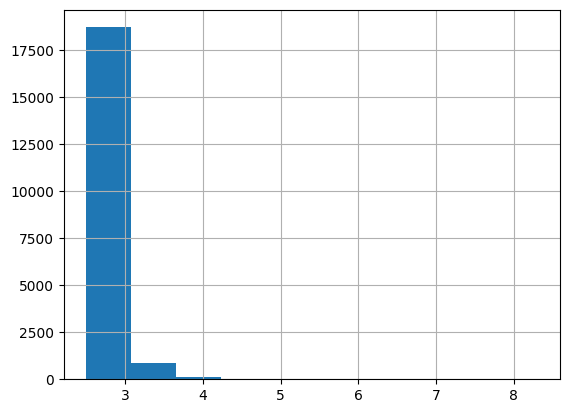

In [35]:
data['ceiling_height'].hist() #большинство кватртир имеют высоту потолков около 2.6 метров

<Axes: >

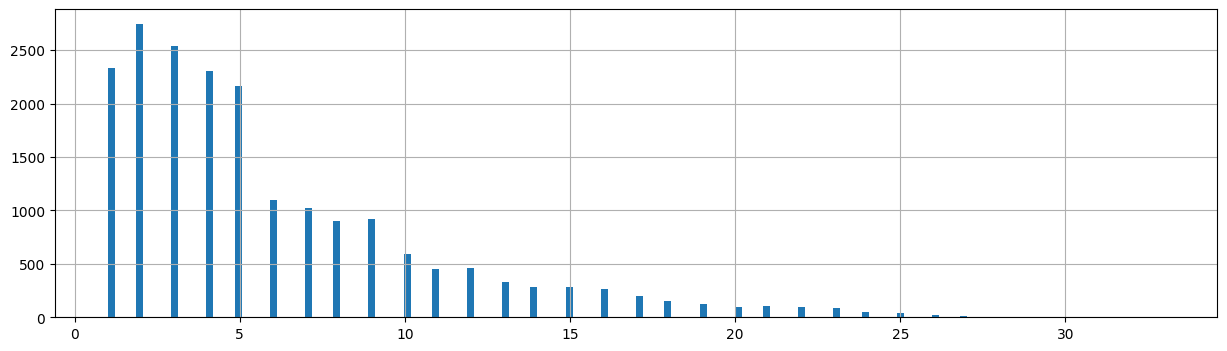

In [36]:
data['floor'].hist(bins =150, figsize=(15,4)) # наблюдаем резкое снижение на 1 и на 5

<Axes: >

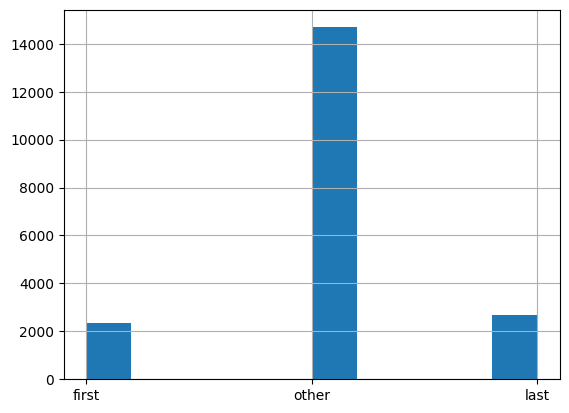

In [37]:
data['type_floor'].hist() # намного бобьше не первых этажей и не последних



<Axes: >

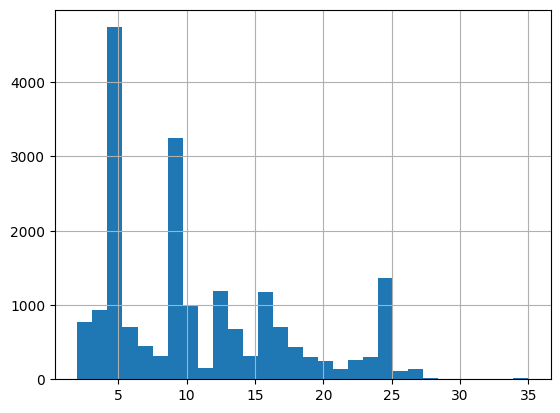

In [38]:
data['floors_total'].hist(bins = 30, range=(2, 35))


<Axes: >

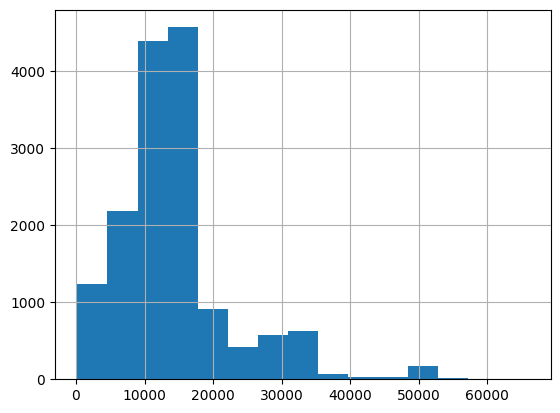

In [39]:
data['city_centers_nearest'].hist(bins = 15)

основное колличество квартир находится на растоянии от 5000м до 18000м от центра города

стандартных 4 и 9 этажных домов больше всего

<Axes: >

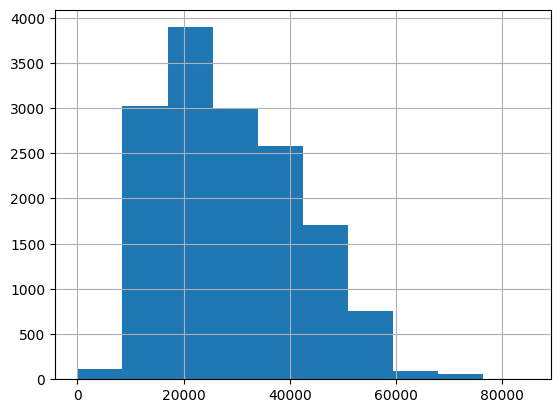

In [40]:
data['airports_nearest'].hist() #в основном расстояние начинается с 10.000м и плавно спускается

<Axes: >

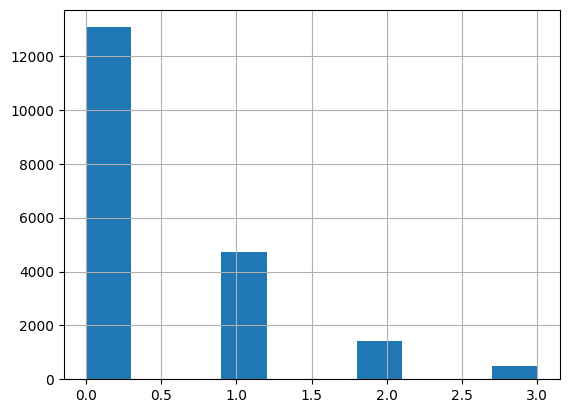

In [41]:
data['parks_around3000'].hist() #В основном в радиусе 500м есть парк, чуть меньше 6000кв имеют кв в радиусе 1км

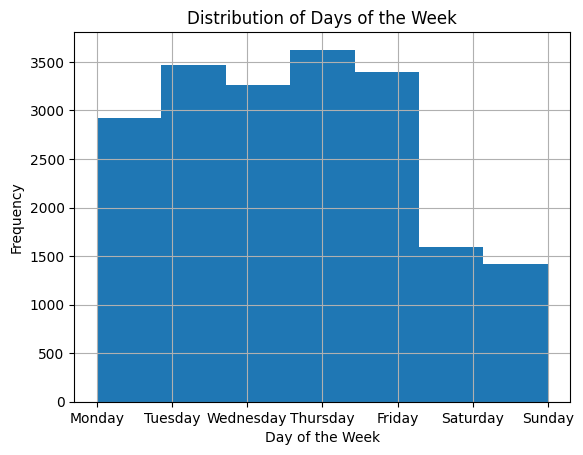

In [42]:
#data['day_week'].hist() #больше объявлений выкладывают по будням

day_order = {'Monday': 1,
            'Tuesday': 2,
            'Wednesday': 3,
            'Thursday': 4,
            'Friday': 5,
            'Saturday': 6,
            'Sunday': 7}


data['day_week_numeric'] = data['day_week'].map(day_order)
data['day_week_numeric'].hist(bins=7)
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Days of the Week')
plt.xticks(list(day_order.values()), list(day_order.keys()))
plt.show()

<Axes: >

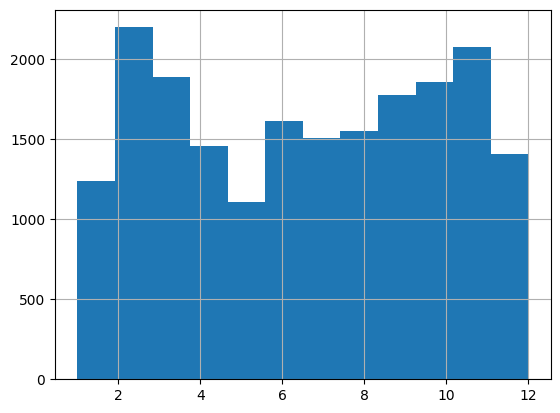

In [43]:
data['nom_month'].hist(bins = 12) #кватриры чаще выставляют на продажу зимой

весной заметин всплеск выкладывания обьявлений, также рост заметин осенью

# example 1

#### example 3

##### example 4

180.37650464726497
95.0


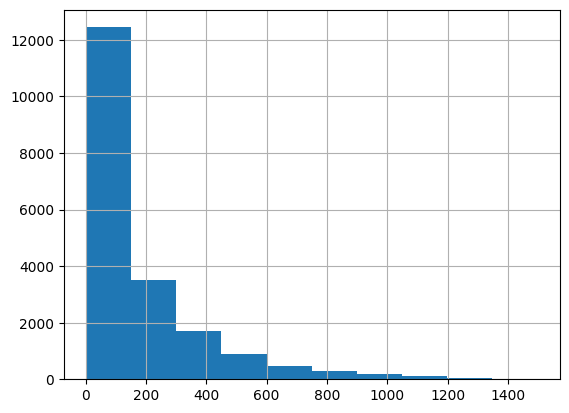

In [44]:
data['days_exposition'].hist()
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

<Axes: >

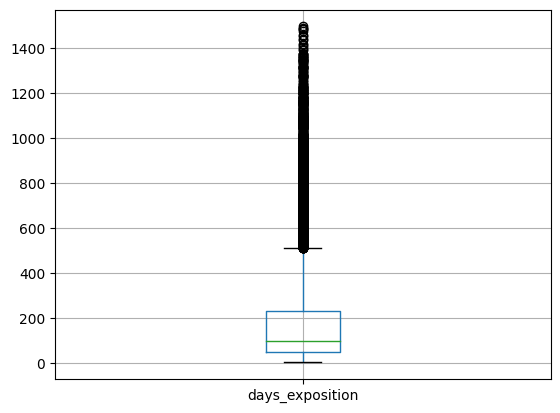

In [45]:
data['days_exposition'].describe()
data.boxplot('days_exposition')

большинсво квартир продаются до 200 дней и эти продажи можно сичтать нормальными то что лежит ниже медианы можно считать быстрыми
то что лежит выше двухсот долгими

<ipython-input-46-3a196345dfc3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True)


<Axes: >

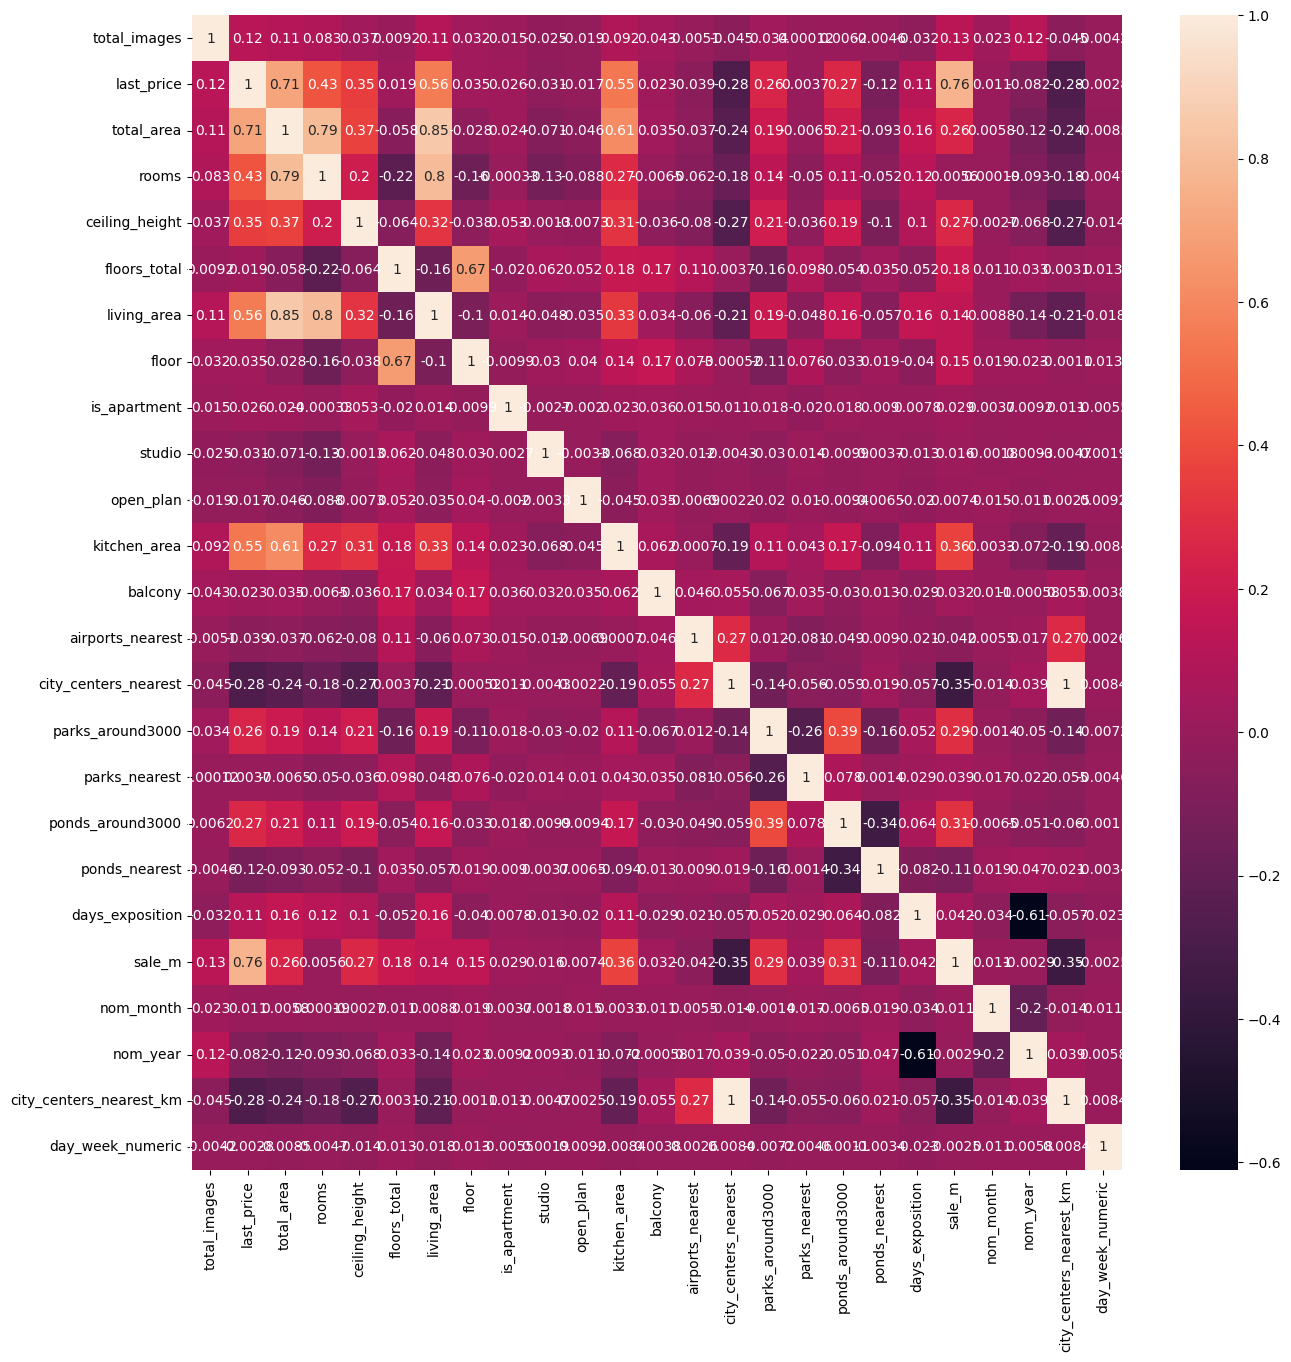

In [46]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(),annot=True)

Выведем полную картину кареляций и и на ней просмотрим интересующие нас закономерности
можем сделать выводы что стоимость квартиры по большей части зависит от общей площади, чуть меньше зависит от площади гостинной и кухни  

количество комнат влияет на стоимость но не значительно



<Axes: xlabel='total_area', ylabel='last_price'>

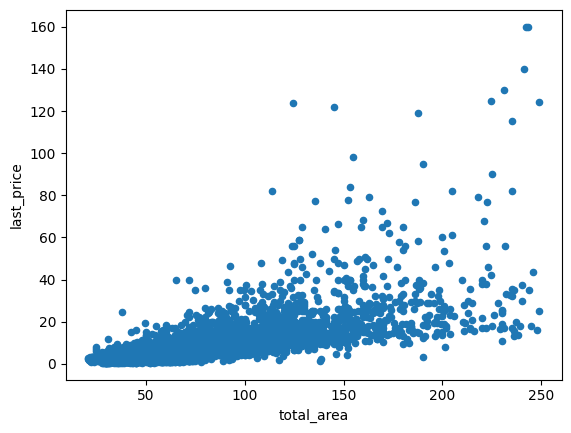

In [47]:
(data
 .pivot_table(index='total_area', values = 'last_price', aggfunc = 'median'))
data['total_area'].corr(data['last_price'])
data.plot(x='total_area', y='last_price', kind='scatter')

<Axes: xlabel='living_area', ylabel='last_price'>

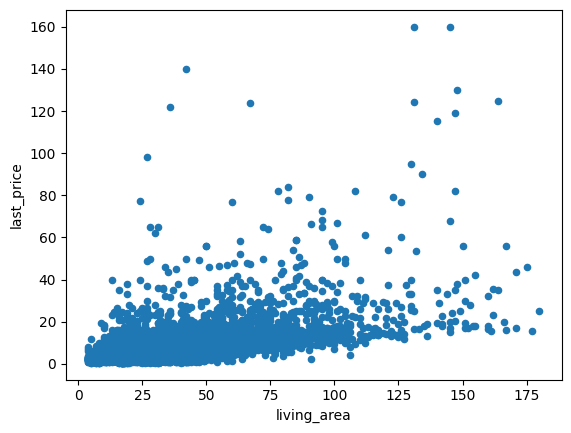

In [48]:
(data.pivot_table(index='living_area', values = 'last_price', aggfunc = 'mean'))
data.plot(x='living_area', y='last_price', kind='scatter')

<Axes: xlabel='kitchen_area', ylabel='last_price'>

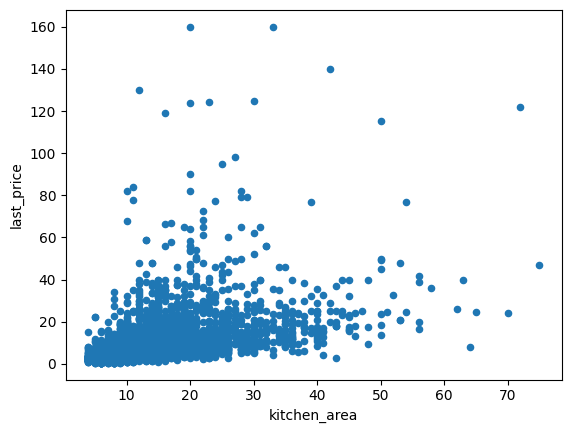

In [49]:
(data.pivot_table(index='kitchen_area', values = 'last_price', aggfunc = 'mean'))

data.plot(x='kitchen_area', y='last_price', kind='scatter')

,last_price
day_week,
Friday,5.764438
Monday,5.845238
Saturday,5.800669
Sunday,5.781082
Thursday,6.132517
Tuesday,5.882173
Wednesday,5.817516


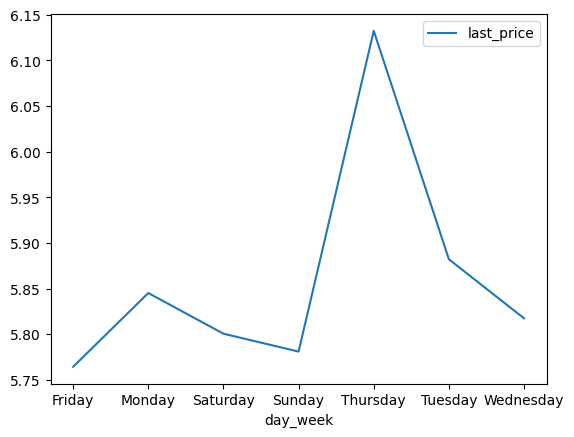

In [50]:
day_price = data.pivot_table(index = 'day_week', values = 'last_price')#
day_price.plot()
day_price


странная зависимость, но обявления опубликованные в субботу в среднем имеют более высокую цену

после исключения выбросов изменилась зависимость теперь более высокая цена по четвергам

,last_price
nom_month,
1,5.940579
2,5.854322
3,5.514370
4,5.829520
5,5.955475
6,5.791010
7,5.987997
8,5.991539
9,6.030678


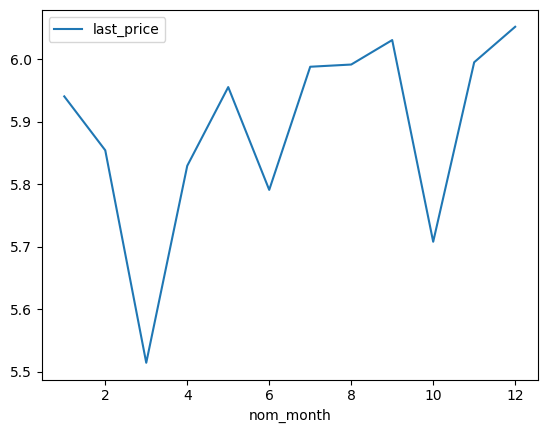

In [51]:
nom_month_price = data.pivot_table(index = 'nom_month', values = 'last_price')#
nom_month_price.plot()
nom_month_price

данные слишком хаотичны, сложно сделать какие либо выводы

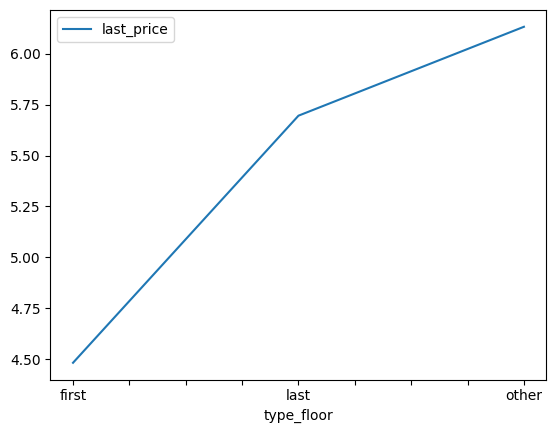

In [52]:
(data
 .pivot_table(index='type_floor', values = 'last_price', aggfunc = 'mean')
 .plot()
);

на первом этаже самые дешевые квартиры, видимо ни кому не нравится первый этаж

кол-во объявлений в 2014: 106
кол-во объявлений в 2018: 7271


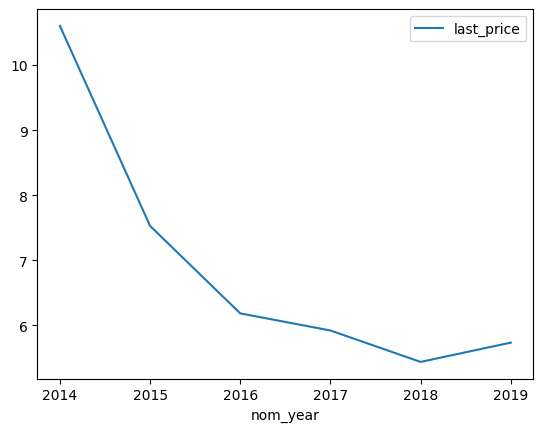

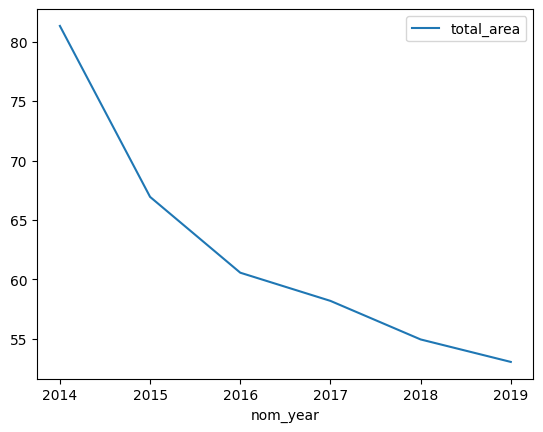

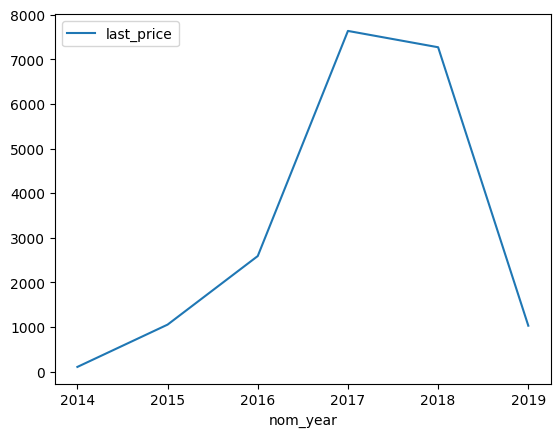

In [53]:
(data
.pivot_table(index='nom_year', values ='last_price',aggfunc = 'mean')
.plot())
(data
.pivot_table(index='nom_year', values ='total_area',aggfunc = 'mean')
.plot())
(data
.pivot_table(index='nom_year', values ='last_price',aggfunc = 'count')
.plot())
y_2014 = data.loc[data['nom_year'] == 2014, 'nom_year'].count()
y_2018 = data.loc[data['nom_year'] == 2018, 'nom_year'].count()

print('кол-во объявлений в 2014:',y_2014)
print('кол-во объявлений в 2018:',y_2018)

<Axes: ylabel='sale_m'>

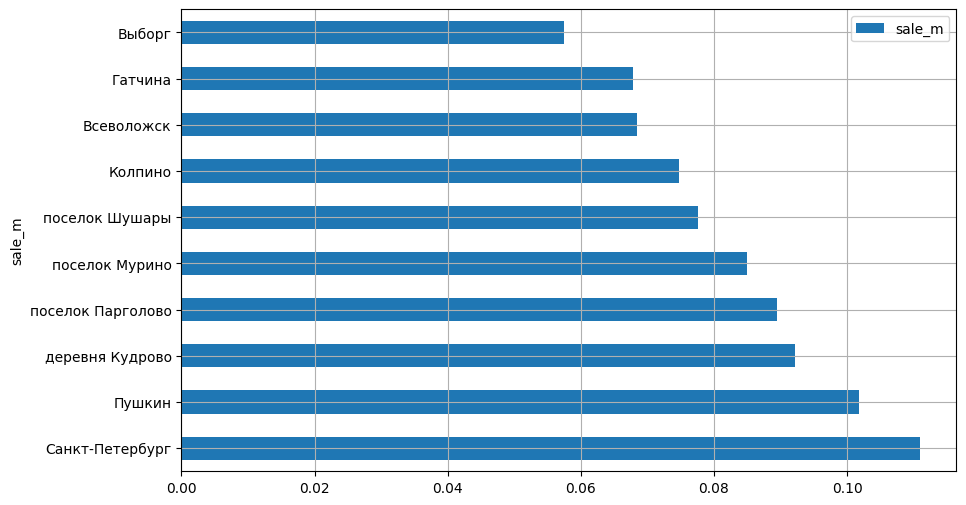

In [54]:
mean_price_m = data['locality_name'].value_counts().head(10)
top_locations_names = list(mean_price_m.index)
(data
 .query('locality_name in @top_locations_names')
 .pivot_table(index = 'locality_name', values = 'sale_m', aggfunc='mean')
 .sort_values(by='sale_m', ascending=False)
 .plot(kind = 'barh',figsize = (10,6), style=('-o'),  grid=True, ylabel= 'sale_m')
)

самая дорогая цена за метр в петербурге, а десятку лидеров закрывает выборг с ценой почти в два раза дешевле


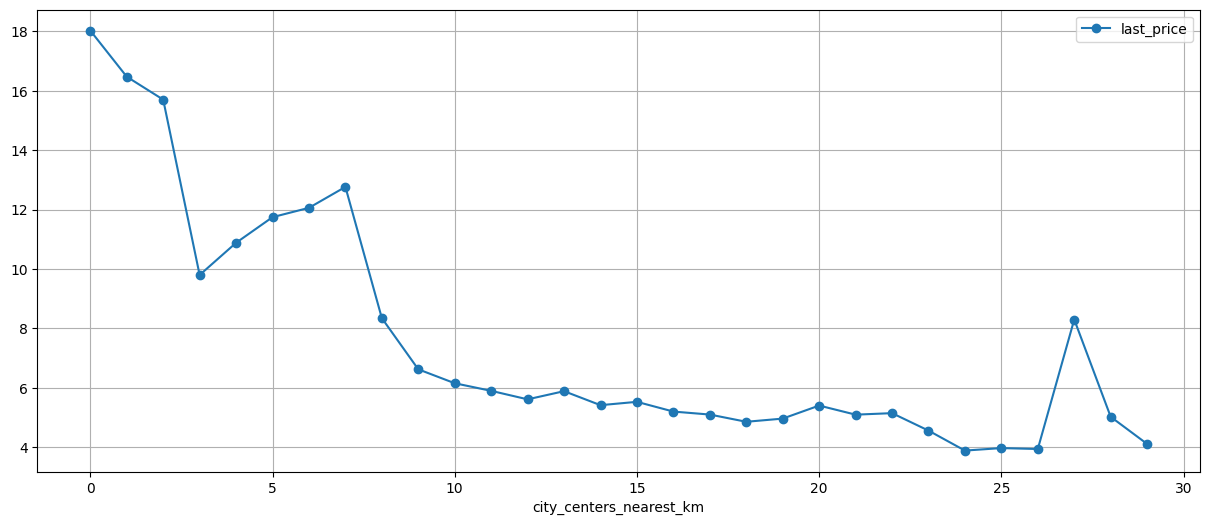

In [55]:
price_km = data['city_centers_nearest_km']

(data
  .query('locality_name == "Санкт-Петербург"')
  .pivot_table(index= 'city_centers_nearest_km', values = 'last_price', aggfunc = 'mean')
  .plot(figsize = (15,6), style=('-o'),  grid=True)
);

в центре очень дорогие квартиры и чем дальше от него тем дешевле
но на 27 км возник выброс возможно это из за высокой стоимость, можно считать ее за выброс

In [56]:
data.loc[(data['city_centers_nearest_km'] == 27) & (data['locality_name'] == 'Санкт-Петербург')].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sale_m,day_week,nom_month,nom_year,type_floor,city_centers_nearest_km,day_week_numeric
748,13,14.35,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0,NaN,128,0.193919,Tuesday,11,2017,other,27.0,2
5961,6,2.25,32.0,2018-02-27,1,2.65,2,16.0,2,False,...,0,NaN,178,0.070312,Tuesday,2,2018,last,27.0,2


In [57]:
floor_1_km_3 = (data
 .loc[(data['city_centers_nearest_km'] == 3) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
floor_1_km_3_2 = floor_1_km_3['other'] /floor_1_km_3.sum()
floor_1_km_3_2

floor_2_km_3 = (data
 .loc[(data['city_centers_nearest_km'] == 3) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
fg = floor_2_km_3['first'] /floor_2_km_3.sum()

ty = (data
 .loc[(data['city_centers_nearest_km'] == 3) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
gh = ty['last'] /ty.sum()

print('На 3 км:')
print('доля первых этажей:',fg.round(3))
print('доля других этажей:',floor_1_km_3_2.round(3))
print('доля последних этажей:',gh.round(3))

На 3 км:
доля первых этажей: 0.161
доля других этажей: 0.598
доля последних этажей: 0.24


In [58]:
floor_1_km_3 = (data
 .loc[(data['city_centers_nearest_km'] == 5) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
floor_1_km_3_2 = floor_1_km_3['other'] /floor_1_km_3.sum()
floor_1_km_3_2

floor_2_km_3 = (data
 .loc[(data['city_centers_nearest_km'] == 5) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
fg = floor_2_km_3['first'] /floor_2_km_3.sum()

ty = (data
 .loc[(data['city_centers_nearest_km'] == 5) & (data['locality_name'] == 'Санкт-Петербург')]
 .value_counts('type_floor'))
gh = ty['last'] /ty.sum()

print('На 5 км:')
print('доля первых этажей:',fg.round(3))
print('доля других этажей:',floor_1_km_3_2.round(3))
print('доля последних этажей:',gh.round(3))

На 5 км:
доля первых этажей: 0.084
доля других этажей: 0.78
доля последних этажей: 0.136


Ближе к центу высота домов меньше

### Общий вывод
Сделав предобработки данных и проведя анализ можно сформулировать выводы:
- На певом и последних этажах квартиры дешевле
- Близость к центру  зависит от цены (но не всегда только это, еще много факторов)
- В Санкт-Петербурге самые дорогие квартиры
- Стоимость квартиры в большей части зависит от площади
- С годами средняя цена квартиры падает это связано с уменьшением средней площади квартир